In [1]:
import lbforaging
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
os.environ['WANDB_SILENT'] = "false"
os.environ['WANDB_START_METHOD'] = "thread"
os.environ['WANDB_MODE'] = "online"

from games.foraging import Foraging
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JALAgent, JALAgentConfig
from utils import plot_training_results
import wandb
from nbconvert import HTMLExporter
import nbformat


In [2]:
def wandb_login():
    wandb.login()

def setup_wandb(config, project_name="foraging_rl", group="jal_vs_iql"):
    """Configura Weights & Biases para tracking de experimentos"""
    if wandb.run is not None:
        wandb.finish()

    # Generar nombre descriptivo para la corrida
    env_name = config['game'].split('-')[0]
    grid_size = config['game'].split('-')[1]
    players = config['game'].split('-')[2]
    food = config['game'].split('-')[3]
    version = config['game'].split('-')[4]
    episodes = config['train_config']['episodes']
    iterations = config['train_config']['iterations']
    # Contar tipos de agentes
    agent_counts = {'jal': 0, 'iql': 0}
    for agent_type in config['agent_types'].values():
        agent_counts[agent_type] += 1
    
    run_name = (f"{env_name}_{grid_size}_{players}p_{food}f_"
               f"JAL{agent_counts['jal']}-IQL{agent_counts['iql']}_"
               f"{time.strftime('%m%d-%H%M')}_{episodes}e_{iterations}i")
    
    # Estructurar mejor la configuración para W&B
    wandb_config = {
        'environment': {
            'name': env_name,
            'grid_size': grid_size,
            'players': players,
            'food': food,
            'version': version,
            'cooperative': 'coop' in config['game']
        },
        'training': {
            'episodes': config['train_config']['episodes'],
            'iterations': config['train_config']['iterations'],
            'total_episodes': config['train_config']['episodes'] * config['train_config']['iterations']
        },
        'agents': {
            'distribution': agent_counts,
            'types': config['agent_types']
        },
        'hyperparameters': {}
    }

    # Agregar hiperparámetros específicos de cada tipo de agente
    for agent_type in ['jal', 'iql']:
        if agent_type in config:
            wandb_config['hyperparameters'][agent_type] = vars(config[agent_type])


    run = wandb.init(
        project=project_name,
        entity="rizzo33-universidad-ort-uruguay",  # Cambia esto por tu entidad de W&B
        group=group,
        name=run_name,
        config=wandb_config,
        save_code=False,
        reinit=True,
        settings=wandb.Settings(
            disable_job_creation=True,  # Evitar problemas con notebooks
            silent=False                # Reducir mensajes de consola
        )
    )

    # Guardar metadata adicional como tags
    tags = [
        f"{grid_size}",
        f"{players}p",
        f"{food}f",
        f"JAL{agent_counts['jal']}",
        f"IQL{agent_counts['iql']}",
        "coop" if 'coop' in config['game'] else "comp"
    ]
    run.tags = tags
    
    return run

def save_notebook_to_html(notebook_path="MA_Foraging.ipynb"):
    """Guarda el notebook como HTML"""
    exporter = HTMLExporter()
    notebook = nbformat.read(notebook_path, as_version=4)
    html, _ = exporter.from_notebook_node(notebook)
    
    os.makedirs("notebook_exports", exist_ok=True)
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    output_path = f"notebook_exports/experiment_{timestamp}.html"
    
    with open(output_path, "w") as f:
        f.write(html)
    
    if wandb.run:
        wandb.save(output_path)
    
    return output_path

In [3]:
wandb.login(key="8c15e4a23489e53756d79a4ac60076b117e45813")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/martinrizzo/.netrc
wandb: Currently logged in as: rizzo33 (rizzo33-universidad-ort-uruguay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
game_config = [
        "Foraging-5x5-2p-1f-v3",
        "Foraging-8x8-2p-1f-v3",
        "Foraging-8x8-3p-1f-v3",
        "Foraging-8x8-3p-1f-coop-v3",
    ]

In [5]:
# Configuración mixta
mixed_config = {
    'game': game_config[0],  # Foraging-5x5-2p-1f-v3
    'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, max_t=10000, seed=1),
    'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.05, epsilon_decay=0.99999, max_t=10000, seed=1),
    'train_config': {
        'episodes': 100,
        'iterations': 50,
    },
    'eval_config': {
    'episodes': 20,
    },
    'agent_types': {
        'agent_0': 'jal',  # Primer agente usa JAL
        'agent_1': 'jal'   # Segundo agente usa IQL
    }
}

# Configuración de IQL vs IQL
iql_config = {
    'game': game_config[0],  # Foraging-5x5-2p-1f-v3
    'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, epsilon_decay=0.99995, max_t=10000, seed=1),
    'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.05, epsilon_decay=0.99999, max_t=10000, seed=1),
    'train_config': {
        'episodes': 100,
        'iterations': 50,
    },
    'eval_config': {
    'episodes': 20,
    },
    'agent_types': {
        'agent_0': 'iql',  # Primer agente usa JAL
        'agent_1': 'iql'   # Segundo agente usa IQL
    }
}


coop_config = {
    'game': game_config[3],  # Foraging-8x8-3p-1f-coop-v3
    'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, epsilon_decay=0.99995, max_t=10000, seed=1),
    'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.05, epsilon_decay=0.99999, max_t=10000, seed=1),
    'train_config': {
        'episodes': 200,
        'iterations': 50,
    },
    'eval_config': {
        'episodes': 20,
    },
    'agent_types': {
        'agent_0': 'iql',  # Primer agente usa JAL
        'agent_1': 'iql',   # Segundo agente usa JAL
        'agent_2': 'iql'   # Tercer agente usa JAL
    }
}
#wandb = setup_wandb(mixed_config, project_name="mixed_foraging")

In [6]:
# Crear el juego
game = Foraging(config=mixed_config['game'], seed=1)

# Crear agentes mixtos
agents = {}
for agent_id in game.agents:
    if mixed_config['agent_types'].get(agent_id, 'iql') == 'jal':
        agents[agent_id] = JALAgent(game, agent_id, coop_config['jal'])
    else:
        agents[agent_id] = IQLAgent(game, agent_id, coop_config['iql'])

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
game.reset()
for agent in game.agents:
    print(f"Agent: {agent}")
    print(f"Observation: {game.observe(agent)}")

Agent: agent_0
Observation: [3. 1. 2. 2. 3. 2. 0. 0. 2.]
Agent: agent_1
Observation: [3. 1. 2. 0. 0. 2. 2. 3. 2.]


In [8]:
def play_episode(game, agents, verbose=False, render=False):

    # Initialize the game
    game.reset()
    step_count = 0

    # Initialize each agent
    for agent in game.agents:
        agents[agent].reset()

    # Print initial observations if verbose is enabled
    if verbose:
        print(f"Step: {step_count}")
        for agent in game.agents:
            print(f"Agent {agent} observe: {game.observe(agent)}")

    # Initialize rewards for each agent
    cum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))
    # render the game if required
    if render:
        game.render()
        time.sleep(0.5)

    while not game.done():

        step_count += 1
        
        # Get actions from each agent
        actions = {}
        for agent in game.agents:
            actions[agent] = agents[agent].action()
             
        # Perform the actions in the game
        game.step(actions)

        # Update the cum_rewards for each agent
        for agent in game.agents:
            reward = game.reward(agent)
            cum_rewards[agent] += reward

        # Print actions, rewards and next state if verbose is enabled
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                    print(f"Agent {agent} action: {actions[agent]} - {game.action_set[actions[agent]]}")
                    print(f"Agent {agent} reward: {game.reward(agent)}")
                    print(f"Agent {agent} observe: {game.observe(agent)}")
            
        if render:
            game.render()
            time.sleep(0.5)
    
        for agent in game.agents:
            # Update the agent with the last observation
            agents[agent].update()
    
    return cum_rewards

In [9]:
def run(game, agents, episodes=1, verbose=False, render=False, log_wandb=False):
    sum_rewards = dict(map(lambda agent: (agent, 0.0), game.agents))
    episodes_length = []
    for _ in range(episodes):
        episode_start = time.time()
        cum_rewards = play_episode(game, agents, verbose=verbose, render=render)
        episode_time = time.time() - episode_start
        for agent in game.agents:
            sum_rewards[agent] += cum_rewards[agent]
        episodes_length.append(episode_time)

        if log_wandb and wandb.run:
            log_data = {f"episode_reward/{agent}": reward for agent, reward in cum_rewards.items()}
            log_data["episode_length"] = episode_time
            wandb.log(log_data)
        
    if verbose:
        print(f"Average rewards over {episodes} episodes:")
        for agent in game.agents:
            print(f"Agent {agent}: {sum_rewards[agent] / episodes}")
    avg_rewards = {agent: sum_rewards[agent] / episodes for agent in game.agents}        
    if log_wandb and wandb.run:
        wandb.log({f"avg_reward/{agent}": avg_r for agent, avg_r in avg_rewards.items()})
        wandb.log({"avg_episode_time": np.mean(episodes_length)})
      
    return sum_rewards     

In [10]:
def train(game, agents, train_config, progress=False, verbose=False, render=False):
    iterations = train_config["iterations"]
    episodes = train_config["episodes"]
    total_episodes = iterations * episodes
    
    # Estadísticas de entrenamiento
    stats = {
        'average_rewards': {agent: [] for agent in game.agents},
        'episode_rewards': {agent: [] for agent in game.agents},
        'exploration_rates': {agent: [] for agent in game.agents},
        'time_per_episode': [],
        'time_per_iteration': [],
        'total_time': 0,
        'start_time': time.strftime("%Y-%m-%d %H:%M:%S"),
        'end_time': None,
        'agent_types': {agent: type(agents[agent]).__name__ for agent in game.agents},
        'environment': str(game.env)
    }
    optimal_reward_per_episode = 1.0 #para roraging

    print(f"🚀 Starting training for {iterations} iterations ({total_episodes} total episodes)")
    start_time = time.time()
    
    # Configurar barra de progreso principal
    pbar = tqdm(total=total_episodes, desc="Training Progress", unit="episode")#, disable=not progress)
    
    for i in range(1, iterations + 1):
        iteration_start = time.time()
        iteration_rewards = {agent: 0.0 for agent in game.agents}
        iteration_exploration = {agent: 0.0 for agent in game.agents}
        
        for e in range(1, episodes + 1):
            episode_start = time.time()
            episode_num = (i - 1) * episodes + e
            
            # Ejecutar episodio
            cum_rewards = play_episode(game, agents, verbose=verbose, render=render)
            
            # Calcular tiempo del episodio
            episode_time = time.time() - episode_start
            stats['time_per_episode'].append(episode_time)

            # Actualizar estadísticas
            for agent in game.agents:
                stats['episode_rewards'][agent].append(cum_rewards[agent])
                iteration_rewards[agent] += cum_rewards[agent]


                if hasattr(agents[agent], 'epsilon'):
                    iteration_exploration[agent] += agents[agent].epsilon
                elif hasattr(agents[agent], 'config') and hasattr(agents[agent].config, 'initial_epsilon'):
                    iteration_exploration[agent] += agents[agent].config.initial_epsilon
            # Loggear en W&B
            if wandb.run:
                log_data = {
                    **{f"live_rewards/{agent}": cum_rewards[agent] for agent in game.agents},
                    "episode": episode_num,
                    "episode_time": episode_time,
                    "global_step": episode_num
                }

                # Agregar exploración si está disponible
                for agent in game.agents:
                    if hasattr(agents[agent], 'epsilon'):
                        log_data[f"exploration/{agent}"] = agents[agent].epsilon

                wandb.log(log_data)
            pbar.update(1)
        

        
        # Tiempo por iteración
        iteration_time = time.time() - iteration_start
        stats['time_per_iteration'].append(iteration_time)
        
        # Guardar promedios por iteración
        for agent in game.agents:
            avg_reward = iteration_rewards[agent] / episodes
            stats['average_rewards'][agent].append(avg_reward)
            stats['exploration_rates'][agent].append(iteration_exploration[agent] / episodes)

            # Loggear en W&B
            if wandb.run:
                wandb.log({
                    f"iteration_avg_reward/{agent}": avg_reward,
                    f"exploration_rate/{agent}": stats['exploration_rates'][agent][-1],
                    "iteration": i,
                    "iteration_time": iteration_time,
                    "global_step": i * episodes
                })

    # Finalizar medición de tiempo
    stats['total_time'] = time.time() - start_time
    stats['end_time'] = time.strftime("%Y-%m-%d %H:%M:%S")
    pbar.close()

    # Guardar resultados finales en W&B
    if wandb.run:
        # Métricas resumen
        summary_metrics = {
            "total_training_time": stats['total_time'],
            "avg_episode_time": np.mean(stats['time_per_episode']),
            "avg_iteration_time": np.mean(stats['time_per_iteration']),
            "episodes_per_second": total_episodes / stats['total_time']
        }
        # Agregar recompensas promedio por agente
        for agent in game.agents:
            summary_metrics[f"final_avg_reward/{agent}"] = np.mean(stats['episode_rewards'][agent][-episodes:])

        wandb.summary.update(summary_metrics)
        
        # Guardar figuras en W&B
        figures = plot_training_results(stats, agents, game, save_local=False)
        for name, fig in figures.items():
            wandb.log({f"charts/{name}": wandb.Image(fig)})
            plt.close(fig)
            
        # Guardar configuración de los agentes
        for agent_id, agent in agents.items():
            if hasattr(agent, 'config'):
                wandb.config.update({f"agent_{agent_id}_config": vars(agent.config)}, allow_val_change=True)

    return stats

In [ ]:
def plot_combined_results(train_stats, eval_stats, agents):
    """Visualización combinada de entrenamiento y evaluación"""
    #plt.figure(figsize=(18, 6))
    
    # Gráfico 1: Progreso de entrenamiento
    #plt.subplot(1, 3, 1)
    # Primero crear y mostrar la figura local
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))

    # Gráfico 1: Progreso de entrenamiento
    for agent_id in train_stats['average_rewards']:
        axs[0].plot(train_stats['average_rewards'][agent_id], 
                label=f"{agent_id} ({type(agents[agent_id]).__name__})")
    axs[0].set_title("Training Progress", fontsize=14)
    axs[0].set_xlabel("Iteration", fontsize=12)
    axs[0].set_ylabel("Average Reward", fontsize=12)
    axs[0].legend(fontsize=10)
    axs[0].grid(True, alpha=0.3)
    
    # Gráfico 2: Recompensas de evaluación
    #plt.subplot(1, 3, 2)
    for agent_id in eval_stats['episode_rewards']:
        rewards = eval_stats['episode_rewards'][agent_id]
        axs[1].scatter(range(len(rewards)), rewards, alpha=0.5, 
                   label=f"{agent_id} eval rewards")
    axs[1].set_title("Evaluation Episode Rewards")
    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Reward")
    axs[1].legend(fontsize=10)
    axs[1].grid(True, alpha=0.3)
    
    # Gráfico 3 alternativo: Histograma apilado
    if 'actions_taken' in eval_stats:
        bottom = np.zeros(6)  # Para el apilamiento
        colors = plt.cm.get_cmap('tab10', len(eval_stats['actions_taken']))
        
        for i, agent_id in enumerate(eval_stats['actions_taken']):
            actions = eval_stats['actions_taken'][agent_id]
            if actions:
                action_counts = np.bincount(actions, minlength=6)
                action_probs = action_counts / len(actions)
                
                axs[2].bar(range(6), action_probs, width=0.8, bottom=bottom,
                        color=colors(i), alpha=0.7,
                        label=f"{agent_id} ({type(agents[agent_id]).__name__})")
                bottom += action_probs
        
        axs[2].set_title("Stacked Policy Distribution", fontsize=14)
        axs[2].set_xlabel("Step", fontsize=12)
        axs[2].set_ylabel("Action", fontsize=12)
        axs[2].set_yticks(range(6))  # Mostrar las 6 acciones posibles
        axs[2].set_ylim(-0.5, 5.5)   # Ajustar límites del eje Y
        axs[2].legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
        axs[2].grid(True, alpha=0.3)
    else:
        axs[2].set_title("No Action Data Available", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    # Guardar en W&B
    if wandb.run:
        import plotly.graph_objects as go
        # Gráfico 1: Progreso de entrenamiento
        train_fig = go.Figure()
        for agent_id in train_stats['average_rewards']:
            train_fig.add_trace(go.Scatter(
                x=list(range(len(train_stats['average_rewards'][agent_id]))),
                y=train_stats['average_rewards'][agent_id],
                name=f"{agent_id} ({type(agents[agent_id]).__name__})",
                mode='lines+markers',
                line=dict(width=2),
                marker=dict(size=4)
            ))
        train_fig.update_layout(
            title="Training Progress",
            xaxis_title="Iteration",
            yaxis_title="Average Reward",
            height=500,
            width=800,
            showlegend=True
        )
        wandb.log({"training_progress": train_fig})
        
        # Gráfico 2: Recompensas de evaluación
        eval_fig = go.Figure()
        for agent_id in eval_stats['episode_rewards']:
            rewards = eval_stats['episode_rewards'][agent_id]
            eval_fig.add_trace(go.Scatter(
                x=list(range(len(rewards))),
                y=rewards,
                name=f"{agent_id} eval rewards",
                mode='markers',
                marker=dict(
                    opacity=0.7,
                    size=8,
                    line=dict(width=1, color='DarkSlateGrey'))
            ))
        eval_fig.update_layout(
            title="Evaluation Episode Rewards",
            xaxis_title="Episode",
            yaxis_title="Reward",
            height=500,
            width=800,
            showlegend=True
        )
        wandb.log({"evaluation_rewards": eval_fig})
        
    

In [15]:
def run_evaluation(game, agents, eval_config, wandb_run=None):
    """
    Ejecuta evaluación sin aprendizaje con logging a W&B
    
    Args:
        game: Entorno del juego
        agents: Diccionario de agentes (deben tener learn=False)
        eval_config: Configuración {'episodes': int}
        wandb_run: Objeto de ejecución de W&B (opcional)
    """
    # Desactivar aprendizaje en todos los agentes
    for agent in agents.values():
        if hasattr(agent, 'learn'):
            agent.learn = False
    
    # Estadísticas de evaluación
    eval_stats = {
        'episode_rewards': {agent_id: [] for agent_id in agents},
        'actions_taken': {agent_id: [] for agent_id in agents}
    }
    
    print("\n=== Evaluación Post-Entrenamiento ===")
    print(f"Ejecutando {eval_config['episodes']} episodios de evaluación...")
    
    for episode in tqdm(range(eval_config['episodes']), desc="Evaluating"):
        # Ejecutar episodio
        rewards = play_episode(game, agents)
        
        # Registrar acciones y recompensas
        for agent_id in agents:
            eval_stats['episode_rewards'][agent_id].append(rewards[agent_id])
            eval_stats['actions_taken'][agent_id].append(agents[agent_id].last_action)
        
        # Loggear en W&B si está disponible
        if wandb_run:
            wandb.log({
                **{f"eval_episode/{agent_id}_reward": rewards[agent_id] for agent_id in agents},
                "eval_episode": episode
            })
    
    # Calcular métricas agregadas
    for agent_id in agents:
        avg_reward = np.mean(eval_stats['episode_rewards'][agent_id])
        eval_stats['avg_rewards'] = eval_stats.get('avg_rewards', {})
        eval_stats['avg_rewards'][agent_id] = avg_reward
        
        if wandb_run:
            # Loggear métricas finales de evaluación
            wandb.log({
                f"eval_final/{agent_id}_avg_reward": avg_reward,
                f"eval_final/{agent_id}_action_distribution": wandb.Histogram(
                    np.array(eval_stats['actions_taken'][agent_id])
                )
            })
    
    return eval_stats

In [16]:
# Ejemplo de configuraciones comparativas
configs = [
    {
        'game': game_config[1],  # Foraging-5x5-2p-1f-v3",
        'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, epsilon_decay=0.99995, max_t=10000, seed=1),
        'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.01, epsilon_decay=0.99995, max_t=10000, seed=34),
        'train_config': {'episodes': 100, 'iterations': 30},
        'eval_config': {'episodes': 50},
        'agent_types': {'agent_0': 'iql', 'agent_1': 'iql'}
    },
    {
        'game': game_config[3],  # Foraging-8x8-3p-1f-coop-v3
        'iql': IQLAgentConfig(alpha=0.2),
        'jal': JALAgentConfig(),
        'train_config': {'episodes': 200, 'iterations': 30},
        'eval_config': {'episodes': 50},
        'agent_types': {'agent_0': 'iql', 'agent_1': 'iql', 'agent_2': 'iql'}
    },
    {
        'game': game_config[0],  # Foraging-5x5-2p-1f-v3",
        'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, epsilon_decay=0.99995, max_t=10000, seed=1),
        'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.01, epsilon_decay=0.99995, max_t=10000, seed=1),
        'train_config': {'episodes': 100, 'iterations': 30},
        'eval_config': {'episodes': 50},
        'agent_types': {'agent_0': 'jal', 'agent_1': 'jal'}
    },
]

#for config in configs:
#   run_configuration(config)

In [17]:
def train_and_evaluate(config):
    """
    Entrenamiento completo + evaluación con logging integrado
    """
    # Configurar W&B
    wandb_run = setup_wandb(config, project_name="foraging_experiments", group='jal vs jal')
    train_config = config['train_config']
    eval_config = config['eval_config']
    game = Foraging(config=config['game'], seed=config.get('seed', 1))
    agents = {}
    for agent_id in game.agents:
        agent_type = config['agent_types'].get(agent_id, 'iql')
        if agent_type == 'jal':
            agents[agent_id] = JALAgent(game, agent_id, config['jal'])
        else:
            agents[agent_id] = IQLAgent(game, agent_id, config['iql'])
    try:
        # Fase de Entrenamiento
        train_stats = train(game, agents, train_config)
        
        # Fase de Evaluación (sin aprendizaje)
        eval_stats = run_evaluation(game, agents, eval_config, wandb_run)
        
        # Visualización de resultados
        plot_combined_results(train_stats, eval_stats, agents)
        
        return {
            'train_stats': train_stats,
            'eval_stats': eval_stats
        }
        
    finally:
        if wandb_run:
            wandb_run.finish()
        save_notebook_to_html()

    


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


🚀 Starting training for 30 iterations (3000 total episodes)


Training Progress:   0%|          | 0/3000 [00:00<?, ?episode/s]/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(
Training Progress: 100%|██████████| 3000/3000 [01:45<00:00, 28.51episode/s]



=== Evaluación Post-Entrenamiento ===
Ejecutando 50 episodios de evaluación...


Evaluating: 100%|██████████| 50/50 [00:01<00:00, 48.17it/s]
/var/folders/16/zvdz10c10fq604t70ld3dj0w0000gn/T/ipykernel_65022/2277223693.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set3', len(eval_stats['actions_taken']))      # Colores pastel diferenciados


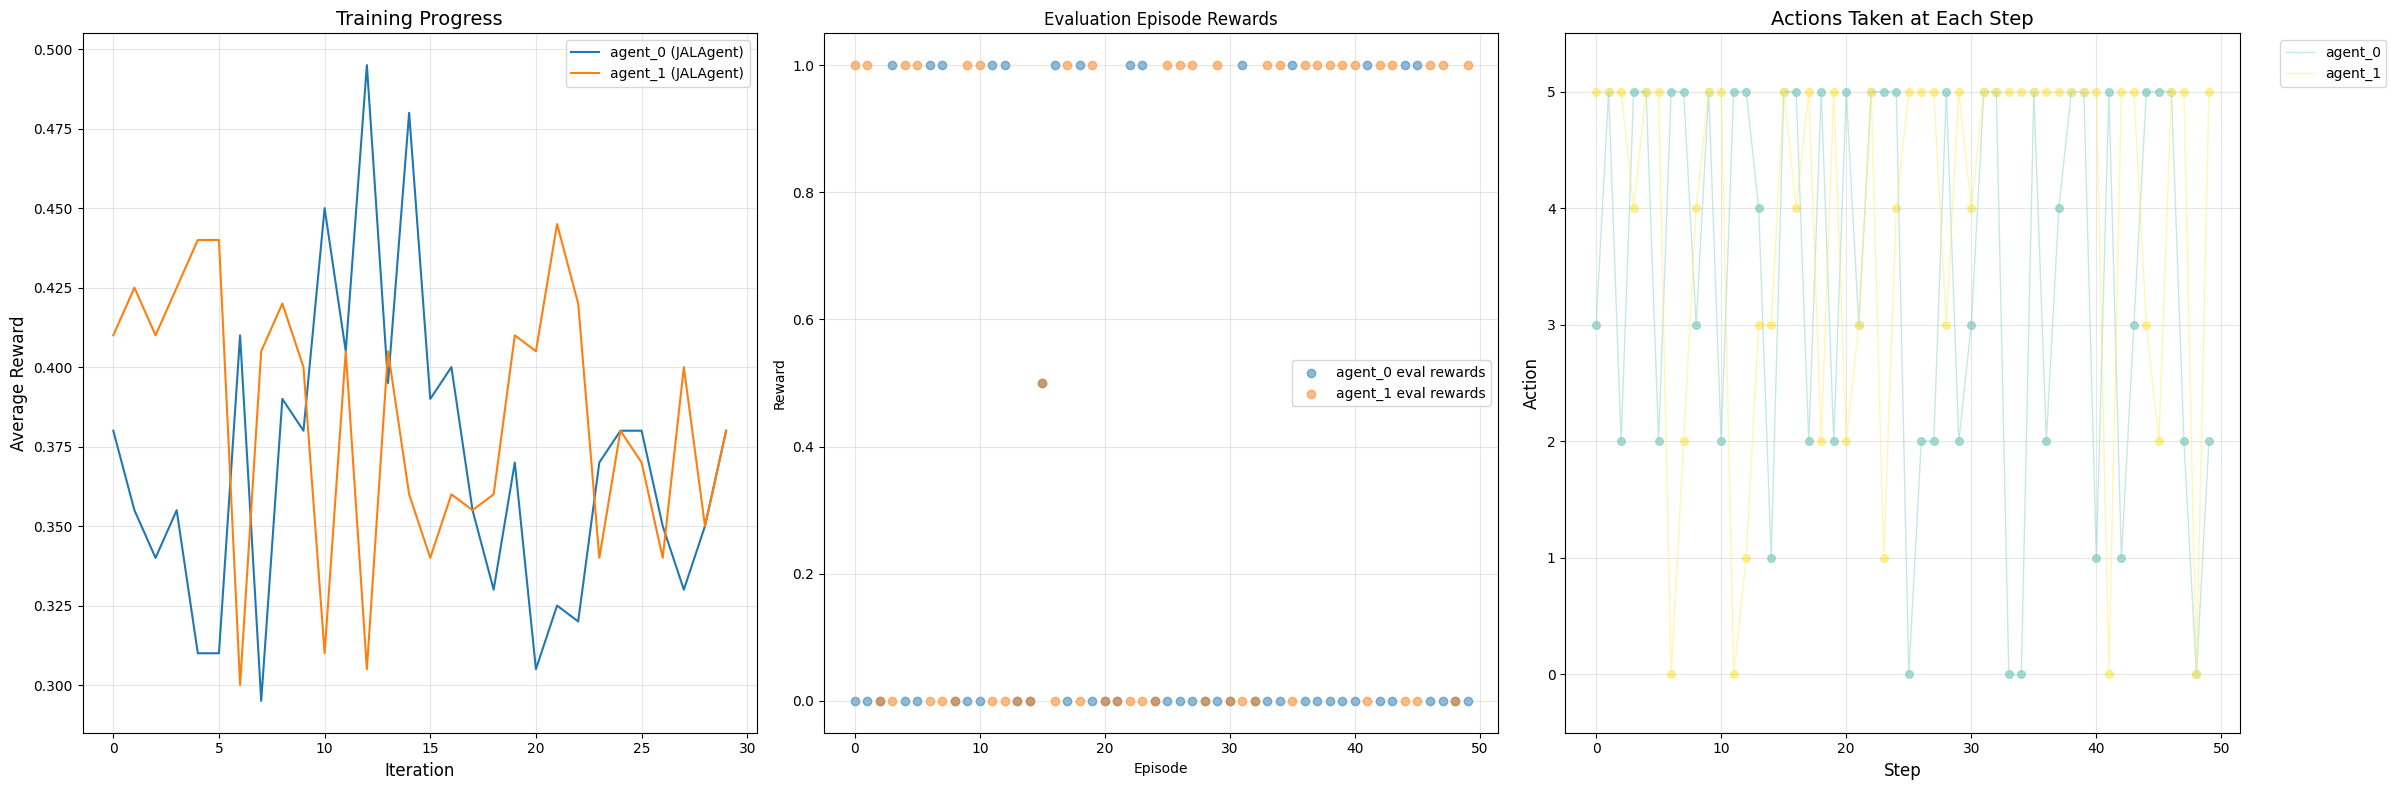

episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█
episode_time,▅▄▁▁▃▂▃▂▃▇█▃▇▆▇▄█▂▇▅▅▃▇▆▆▂█▃██▂▃▇▅▃▂▁█▅▇
eval_episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval_episode/agent_0_reward,▁▁▁█▁██▁▁▁█▁▁▅█▁▁▁██▁▁▁▁▁█▁▁▁█▁▁▁█▁██▁▁▁
eval_episode/agent_1_reward,█▁▁██▁▁██▁▁▁▅▁██▁▁▁▁███▁█▁▁██▁████▁▁▁███
eval_final/agent_0_avg_reward,▁
eval_final/agent_1_avg_reward,▁
exploration_rate/agent_0,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
exploration_rate/agent_1,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
iteration,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██


{'train_stats': {'average_rewards': {'agent_0': [0.38,
    0.355,
    0.34,
    0.355,
    0.31,
    0.31,
    0.41,
    0.295,
    0.39,
    0.38,
    0.45,
    0.405,
    0.495,
    0.395,
    0.48,
    0.39,
    0.4,
    0.355,
    0.33,
    0.37,
    0.305,
    0.325,
    0.32,
    0.37,
    0.38,
    0.38,
    0.35,
    0.33,
    0.35,
    0.38],
   'agent_1': [0.41,
    0.425,
    0.41,
    0.425,
    0.44,
    0.44,
    0.3,
    0.405,
    0.42,
    0.4,
    0.31,
    0.405,
    0.305,
    0.405,
    0.36,
    0.34,
    0.36,
    0.355,
    0.36,
    0.41,
    0.405,
    0.445,
    0.42,
    0.34,
    0.38,
    0.37,
    0.34,
    0.4,
    0.35,
    0.38]},
  'episode_rewards': {'agent_0': [0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    1.0,
    0.0,
    1.0,
    1.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    1.0,
    0.0,
    1.0,
    0.0,
    1.0,
    0.5,
    0.0,
    0.0,
    0.0,


In [18]:
train_and_evaluate(configs[2])